In [1]:
import os
import sys
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

import cv2

from tqdm import tqdm_notebook, tnrange, tqdm
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input, Dropout
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

from scipy import misc, ndimage
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from skimage.morphology import reconstruction, disk
from skimage.filters import rank
from skimage import img_as_float, exposure

import tensorflow as tf
from imgaug import augmenters as iaa
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from sklearn.model_selection import train_test_split

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Set some parameters
im_width = 128
im_height = 128
im_chan = 1
img_size_ori = 101

path_train = '../data/train/'
path_test = '../data/test/'

## Fetch data

In [3]:
train_ids = next(os.walk(path_train+"images"))[2]
test_ids = next(os.walk(path_test+'images'))[2]

In [4]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i

In [5]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
coverage = np.zeros((len(train_ids), 2), dtype=np.float32)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.uint8)

print('Getting and resizing train images and mask ...')
sys.stdout.flush()

for n, id_ in enumerate(tqdm_notebook(train_ids)):
    path = path_train
    img = load_img(path + '/images/' + id_, color_mode = "grayscale")
    x = img_to_array(img)
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_train[n] = x
    
    mask = img_to_array(load_img(path + '/masks/' + id_, color_mode = "grayscale"))
    Y_train[n] = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)
    
    coverage[n, 0] = (mask / 255).sum() / img_size_ori**2
    coverage[n, 1] = cov_to_class(coverage[n, 0])
    
print('Done!')

Getting and resizing train images and mask ...


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "



Done!


## Create train/validation split stratified by salt coverage

In [6]:
x_train, x_valid, y_train, y_valid, cov_train, cov_valid = train_test_split(
X_train, Y_train, coverage, test_size=0.1, stratify=coverage[:, 1], random_state=1337)

In [7]:
x_train.shape

(3600, 128, 128, 1)

## Data augmentation

In [8]:
x_train = np.append(x_train, np.array( [np.fliplr(x) for x in x_train]), 0)
y_train = np.append(y_train, np.array( [np.fliplr(x) for x in y_train]), 0)
print('Flip left right done')
print(x_train.shape)

Flip left right done
(7200, 128, 128, 1)


In [9]:
def filtering_regional_maxima(img):
    image = img_as_float(img)
    image = ndimage.gaussian_filter(image, 1)
    
    seed = np.copy(image)
    seed[1:-1, 1:-1] = image.min()
    mask = image
    dilated = reconstruction(seed, mask, method='dilation') * 255
    return np.array(dilated, dtype=np.uint8)

x_train_ = np.append(x_train, np.array( [filtering_regional_maxima(x) for x in tqdm_notebook(x_train)]), 0)
y_train_ = np.vstack([y_train, y_train.copy()])
print('Filtering done')


Filtering done


In [10]:
print(x_train_.shape)

(14400, 128, 128, 1)


In [11]:
def global_equalize(img):
    return np.array(exposure.equalize_hist(img) * 255, dtype=np.uint8)

x_train_ = np.append(x_train_, np.array([global_equalize(x) for x in tqdm_notebook(x_train)]), 0)
y_train_ = np.vstack([y_train_, y_train.copy()])
print('Global equalize done')
print(x_train_.shape)
print(y_train_.shape)

/usr/local/lib/python3.5/dist-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "



Global equalize done
(21600, 128, 128, 1)
(21600, 128, 128, 1)


In [12]:
def elastic_transform(image, alpha, sigma, seed=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
    
    if seed is None:
        random_state = np.random.RandomState()
    else:
        random_state = np.random.RandomState(seed=seed)
    
    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))

    return map_coordinates(image, indices, order=1).reshape(shape)

x_train_ = np.append(x_train_, np.array([np.expand_dims(elastic_transform(x.squeeze(), 20, 4, 20), -1) 
                              for x in tqdm_notebook(x_train)]), 0)
y_train_ = np.append(y_train_, np.array([np.expand_dims(elastic_transform(x.squeeze(), 20, 4, 20), -1) 
                              for x in tqdm_notebook(y_train)]), 0)

print('Elastic transform done')
print(x_train_.shape)
print(y_train_.shape)


Elastic transform done
(28800, 128, 128, 1)
(28800, 128, 128, 1)


In [13]:
y_train_ = np.piecewise(y_train_, [y_train_ > 125, y_train_ < 125], [1, 0])

In [14]:
y_valid = np.piecewise(y_valid, [y_valid > 125, y_valid < 125], [1, 0])

## Build Model

In [15]:
# Build U-Net Model
def create_model():
    inputs = Input((im_height, im_width, im_chan))
    s = Lambda(lambda x: x/255)(inputs)

    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(0.25)(p1)

    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(0.5)(p2)

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(0.5)(p3)

    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(0.5)(p4)

    c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.5)(u6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.5)(u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.5)(u8)
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(0.5)(u9)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [16]:
def fit(model, X_train, Y_train, output_name):
    earlystopper = EarlyStopping(patience=10, verbose=1)
    checkpointer = ModelCheckpoint('{}.h5'.format(output_name), verbose=1, save_best_only=True)
    reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)
    
    results = model.fit(X_train, Y_train, validation_data=[x_valid, y_valid], batch_size=128, epochs=100, 
                        callbacks=[earlystopper, checkpointer, reduce_lr])
    return results

In [17]:
%%time
amodel = create_model()
history = fit(amodel, x_train_, y_train_, 'model')

Train on 28800 samples, validate on 400 samples
Epoch 1/100
28800/28800 [==============================] - 29s 1ms/step - loss: 0.5407 - acc: 0.7385 - val_loss: 0.4808 - val_acc: 0.7526

Epoch 00001: val_loss improved from inf to 0.48080, saving model to model.h5
Epoch 2/100
28800/28800 [==============================] - 24s 841us/step - loss: 0.4066 - acc: 0.8065 - val_loss: 0.3039 - val_acc: 0.8718

Epoch 00002: val_loss improved from 0.48080 to 0.30394, saving model to model.h5
Epoch 3/100
28800/28800 [==============================] - 25s 854us/step - loss: 0.3139 - acc: 0.8764 - val_loss: 0.2647 - val_acc: 0.8953

Epoch 00003: val_loss improved from 0.30394 to 0.26468, saving model to model.h5
Epoch 4/100
28800/28800 [==============================] - 25s 859us/step - loss: 0.2735 - acc: 0.8943 - val_loss: 0.2375 - val_acc: 0.9050

Epoch 00004: val_loss improved from 0.26468 to 0.23750, saving model to model.h5
Epoch 5/100
28800/28800 [==============================] - 25s 858us/s

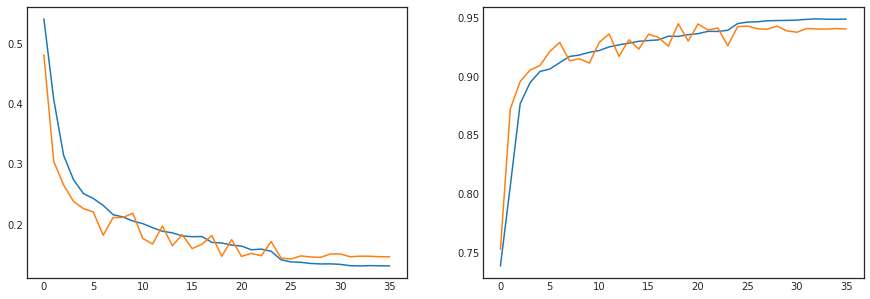

In [18]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_acc.plot(history.epoch, history.history["acc"], label="Train accuracy")
ax_acc.plot(history.epoch, history.history["val_acc"], label="Validation accuracy")

In [19]:
model = load_model('model.h5')

In [20]:
def downsample(img):
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

In [21]:
preds_valid = model.predict(x_valid).reshape(-1, im_height, im_width)

Text(0.5,0.98,'Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

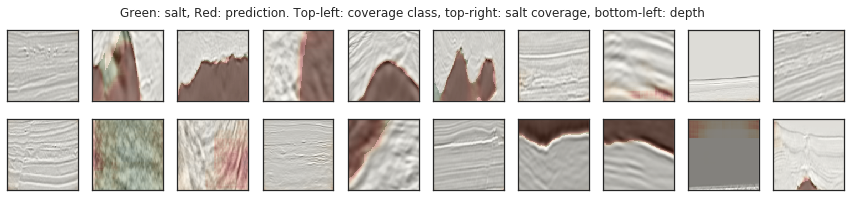

In [22]:
max_images = 20
grid_width = 10
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(15,3))
for idx in range(max_images):
    img = x_valid[idx]
    mask = y_valid[idx]
    pred = preds_valid[idx]
    
    ax = axs[int(idx / grid_width), idx % grid_width]
    ax.imshow(img.squeeze(), cmap="Greys")
    ax.imshow(mask.squeeze(), alpha=0.3, cmap="Greens")
    ax.imshow(pred, alpha=0.3, cmap="OrRd")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

In [23]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(y_valid, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])

In [24]:
threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

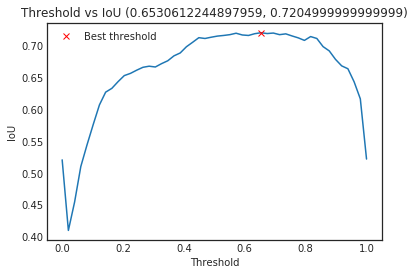

In [25]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [26]:
X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)

sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in enumerate(tqdm_notebook(test_ids)):
    path = path_test
    img = load_img(path + '/images/' + id_)
    x = img_to_array(img)[:,:,1]
    sizes_test.append([x.shape[0], x.shape[1]])
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_test[n] = x

print('Done!')

preds_test = (model.predict(X_test, verbose=1) > threshold_best).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = [np.squeeze(downsample(x)) for x in preds_test]

Getting and resizing test images ... 


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "



Done!
18000/18000 [==============================] - 5s 288us/step


In [27]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

pred_dict = {fn[:-4]:RLenc(np.round(preds_test_upsampled[i])) for i,fn in enumerate(tqdm_notebook(test_ids))}

In [28]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')